In [62]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f #There are lots of functions under f
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, StringIndexer, OneHotEncoder
import matplotlib.pyplot as plt
from scipy.stats import probplot
import seaborn
import shutil
import os

In [41]:
# Initialize Spark Session:
spark = SparkSession.builder.appName("StrokeDiagnosis").getOrCreate()

In [106]:
# Function to extract data
def extract_data():
    # Extract data from CSV files
    patients = spark.read.csv('Patients.csv', header=True, inferSchema=True)
    doctors = spark.read.csv('Doctors.csv', header=True, inferSchema=True)
    hospitals = spark.read.csv('Hospitals.csv', header=True, inferSchema=True)
    medications = spark.read.csv('Medications.csv', header=True, inferSchema=True)
    patient_visits = spark.read.csv('PatientVisits.csv', header=True, inferSchema=True)
    biometrics = spark.read.csv('Biometrics.csv', header=True, inferSchema=True)
    return patients, doctors, hospitals, medications, patient_visits, biometrics

# Function to transform data
def transform_data(patients, doctors, hospitals, medications, patient_visits, biometrics):
    # Correct data types
    spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
    patients = patients.withColumn("BirthDate", f.to_date(f.col("BirthDate"), "dd/MM/yyyy"))
    patient_visits = patient_visits.withColumn("VisitDate", f.to_date(f.col("VisitDate"), "yyyy-MM-dd"))
    patients = patients.withColumn("Annual Income", f.col("Annual Income").cast("double"))
    biometrics = biometrics.withColumn("Height", f.col("Height").cast("double"))
    biometrics = biometrics.withColumn("Weight", f.col("Weight").cast("double"))
    biometrics = biometrics.withColumn("BloodPressure", f.col("BloodPressure").cast("double"))
    biometrics = biometrics.withColumn("HeartRate", f.col("HeartRate").cast("double"))
    
    # Remove duplicate rows
    patients = patients.dropDuplicates()
    doctors = doctors.dropDuplicates()
    hospitals = hospitals.dropDuplicates()
    medications = medications.dropDuplicates()
    patient_visits = patient_visits.dropDuplicates()
    biometrics = biometrics.dropDuplicates()
    
    # Handling Missing Values

    # Fill missing values in categorical columns with the mode
    mode_gender = patients.groupBy("Gender").agg(f.count("Gender").alias("count")).orderBy(f.col("count").desc()).first()[0]
    patients = patients.fillna({'FirstName': 'Unknown', 'LastName': 'Unknown', 'Gender': mode_gender})

    # Fill missing value of Height with mean value
    col_name = 'Height'
    mean_value = biometrics.select(f.mean(f.col(col_name))).collect()[0][0]
    biometrics = biometrics.withColumn(col_name, f.when(f.col(col_name).isNull(), f.lit(mean_value)).otherwise(f.col(col_name)))

    # Handling outliers for BloodPressure and HeartRate
    mean_blood_pressure = biometrics.agg(f.mean(f.when(f.col("BloodPressure") <= 250, f.col("BloodPressure")).otherwise(0))).collect()[0][0]
    biometrics = biometrics.withColumn("BloodPressure", f.when(f.col("BloodPressure") > 250, f.lit(mean_blood_pressure)).otherwise(f.col("BloodPressure")))
    mean_heart_rate = biometrics.agg(f.mean(f.when(f.col("HeartRate") <= 200, f.col("HeartRate")).otherwise(0))).collect()[0][0]
    biometrics = biometrics.withColumn("HeartRate", f.when(f.col("HeartRate") > 200, f.lit(mean_heart_rate)).otherwise(f.col("HeartRate")))

    # Fill missing values in numerical columns with the mean
    for col_name in ['Annual Income']:
        mean_value = patients.agg(f.mean(f.col(col_name)).alias(col_name)).collect()[0][col_name]
        patients = patients.withColumn(col_name, f.when(f.col(col_name).isNull(), f.lit(mean_value)).otherwise(f.col(col_name)))

    for col_name in ['BloodPressure', 'HeartRate']:
        mean_value = biometrics.agg(f.mean(f.col(col_name)).alias(col_name)).collect()[0][col_name]
        biometrics = biometrics.withColumn(col_name, f.when(f.col(col_name).isNull(), f.lit(mean_value)).otherwise(f.col(col_name)))
    
    # Replace NaN with 0 and "Stroke" with 1 in the 'Diagnosis' column
    patient_visits = patient_visits.withColumn('Diagnosis', f.when(f.col('Diagnosis').isNull(), f.lit(0)).otherwise(f.col('Diagnosis')))
    patient_visits = patient_visits.withColumn('Diagnosis', f.when(f.col('Diagnosis') == 'Stroke', f.lit(1)).otherwise(f.col('Diagnosis')))
    
    # Normalize numerical data using Min-Max scaling
    def normalize_column(df, input_col):
        max_val = df.agg({input_col: "max"}).collect()[0][0]
        min_val = df.agg({input_col: "min"}).collect()[0][0]
        df = df.withColumn(input_col+"_Normalized", (f.col(input_col) - min_val) / (max_val - min_val))
        return df

    biometrics = normalize_column(biometrics, 'Height')
    biometrics = normalize_column(biometrics, 'Weight')
    biometrics = normalize_column(biometrics, 'BloodPressure')
    biometrics = normalize_column(biometrics, 'HeartRate')
    patients = normalize_column(patients, 'Annual Income')
    
    biometrics = biometrics.drop("PatientID")
    
    # Rename columns in doctors and hospitals to avoid conflicts
    doctors = doctors.withColumnRenamed("FirstName", "DoctorFirstName").withColumnRenamed("LastName", "DoctorLastName")
    hospitals = hospitals.withColumnRenamed("HospitalID", "HospitalID_Hospital")
    patient_visits = patient_visits.withColumnRenamed("HospitalID", "HospitalID_Visit")

    # Merge datasets
    combined_data = patient_visits.join(patients, on="PatientID", how="inner").join(doctors, on="DoctorID", how="inner").join(hospitals, patient_visits["HospitalID_Visit"] == hospitals["HospitalID_Hospital"], how="inner").join(biometrics, on=["BiometricsID"], how="inner").join(medications, on=["MedicationID"], how="left_outer")
    return combined_data

def load_data(combined_data):
    # Save the combined dataset
    combined_data.coalesce(1).write.csv('CombinedData.csv', header=True, mode='overwrite')

def etl():
    patients, doctors, hospitals, medications, patient_visits, biometrics = extract_data()
    combined_data = transform_data(patients, doctors, hospitals, medications, patient_visits, biometrics)
    load_data(combined_data)

In [ ]:
# ETL Pipeline
etl()

In [118]:
combined_data = spark.read.csv('CombinedData.csv', header=True, inferSchema=True)
# Task 8a: Summary Statistics
print("Summary Statistics:")
combined_data.toPandas().describe()

Summary Statistics:


MedicationID  BiometricsID     DoctorID    PatientID      VisitID  \
count    440.000000   4726.000000  4726.000000  4726.000000  4726.000000   
mean       1.963636   2363.500000    15.260686   515.259839  2363.500000   
std        0.809142   1364.423016     8.847620   289.702511  1364.423016   
min        1.000000      1.000000     1.000000     1.000000     1.000000   
25%        1.000000   1182.250000     7.000000   256.000000  1182.250000   
50%        2.000000   2363.500000    15.000000   524.000000  2363.500000   
75%        3.000000   3544.750000    23.000000   773.000000  3544.750000   
max        3.000000   4726.000000    30.000000  1000.000000  4726.000000   

       HospitalID_Visit    Diagnosis   Annual Income  \
count       4726.000000  4726.000000     4726.000000   
mean           5.542107     0.093102   137329.504062   
std            2.909613     0.290606    40054.760122   
min            1.000000     0.000000    60023.000000   
25%            3.000000     0.000000   111022.000000   
50%            6.000000     0.000000   135512.000000   
75%            8.000000     0.000000   166163.000000   
max           10.000000     1.000000  1000000.000000   

       Annual Income_Normalized   HospitalID  HospitalID_Hospital  \
count               4726.000000  4726.000000          4726.000000   
mean                   0.082243     6.069403             5.542107   
std                    0.042612     2.700313             2.909613   
min                    0.000000     1.000000             1.000000   
25%                    0.054256     4.000000             3.000000   
50%                    0.080309     7.000000             6.000000   
75%                    0.112918     8.000000             8.000000   
max                    1.000000    10.000000            10.000000   

       NumberOfBeds       Height       Weight  BloodPressure    HeartRate  \
count   4726.000000  4726.000000  4726.000000    4726.000000  4726.000000   
mean     210.901820   176.229630    97.476936     104.546461    71.686971   
std      129.281425     9.928185    27.390351      16.594527     8.126505   
min       52.000000   150.000000    45.000000      90.000000    60.000000   
25%      101.000000   169.000000    75.000000      95.000000    65.000000   
50%      145.000000   177.000000    94.000000     101.000000    71.000000   
75%      307.000000   184.000000   119.000000     107.000000    77.000000   
max      454.000000   197.000000   150.000000     180.000000   100.000000   

       Height_Normalized  Weight_Normalized  BloodPressure_Normalized  \
count        4726.000000        4726.000000               4726.000000   
mean            0.558077           0.499780                  0.161627   
std             0.211238           0.260860                  0.184384   
min             0.000000           0.000000                  0.000000   
25%             0.404255           0.285714                  0.055556   
50%             0.574468           0.466667                  0.122222   
75%             0.723404           0.704762                  0.188889   
max             1.000000           1.000000                  1.000000   

       HeartRate_Normalized  
count           4726.000000  
mean               0.292174  
std                0.203163  
min                0.000000  
25%                0.125000  
50%                0.275000  
75%                0.425000  
max                1.000000

In [119]:
# Task 8b: Distribution of Annual Income
annual_income_data = combined_data.select("Annual Income").dropna().rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 6))
plt.hist(annual_income_data, bins=20, color='blue', edgecolor='black')
plt.title("Distribution of Annual Income")
plt.xlabel("Annual Income")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

24/08/25 20:44:00 ERROR Executor: Exception in task 0.0 in stage 2132.0 (TID 1561)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1100, in main
    raise PySparkRuntimeError(
pyspark.errors.exceptions.base.PySparkRuntimeError: [PYTHON_VERSION_MISMATCH] Python in worker has different version (3, 11) than that in driver 3.9, PySpark cannot run with different minor versions.
Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at o

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 2132.0 failed 1 times, most recent failure: Lost task 0.0 in stage 2132.0 (TID 1561) (192.168.1.110 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1100, in main
    raise PySparkRuntimeError(
pyspark.errors.exceptions.base.PySparkRuntimeError: [PYTHON_VERSION_MISMATCH] Python in worker has different version (3, 11) than that in driver 3.9, PySpark cannot run with different minor versions.
Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:564)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:832)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1100, in main
    raise PySparkRuntimeError(
pyspark.errors.exceptions.base.PySparkRuntimeError: [PYTHON_VERSION_MISMATCH] Python in worker has different version (3, 11) than that in driver 3.9, PySpark cannot run with different minor versions.
Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	... 1 more


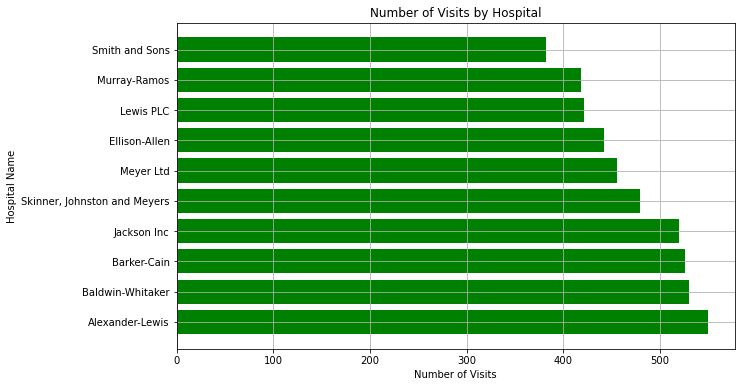

In [108]:
# Task 8c: Distribution of Visits by Hospital
visits_by_hospital = combined_data.groupBy("HospitalName").count().orderBy(f.desc("count")).toPandas()
plt.figure(figsize=(10, 6))
plt.barh(visits_by_hospital['HospitalName'], visits_by_hospital['count'], color='green')
plt.title("Number of Visits by Hospital")
plt.xlabel("Number of Visits")
plt.ylabel("Hospital Name")
plt.grid(True)
plt.show()


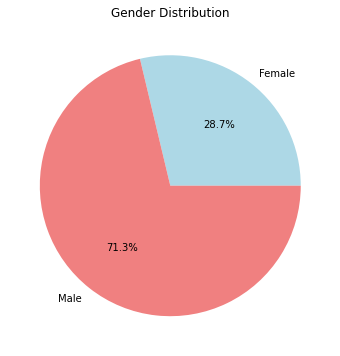

In [109]:
# Task 8d: Gender Distribution
gender_distribution = combined_data.groupBy("Gender").count().toPandas()
plt.figure(figsize=(6, 6))
plt.pie(gender_distribution['count'], labels=gender_distribution['Gender'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title("Gender Distribution")
plt.show()

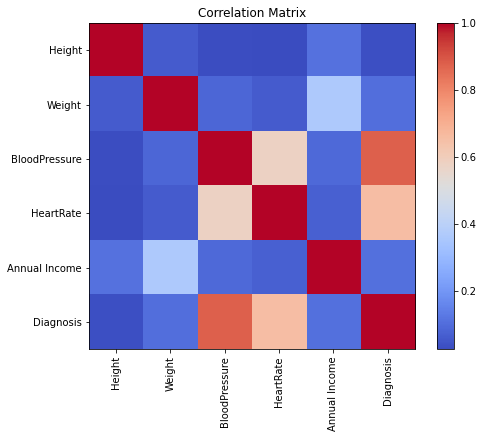

In [110]:
# Task 8e: Correlation Matrix
numeric_columns = ["Height", "Weight", "BloodPressure", "HeartRate", "Annual Income", "Diagnosis"]
correlation_matrix = combined_data.select(numeric_columns).toPandas().corr()
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Correlation Matrix")
plt.show()

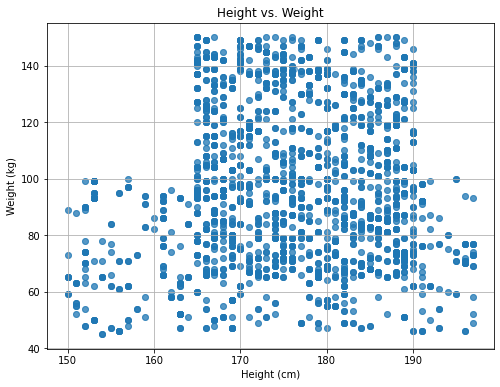

In [111]:
# Task 8f: Scatter Plot (Height vs. Weight)
height_weight_data = combined_data.select("Height", "Weight").dropna().toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(height_weight_data['Height'], height_weight_data['Weight'], alpha=0.5)
plt.title("Height vs. Weight")
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")
plt.grid(True)
plt.show()

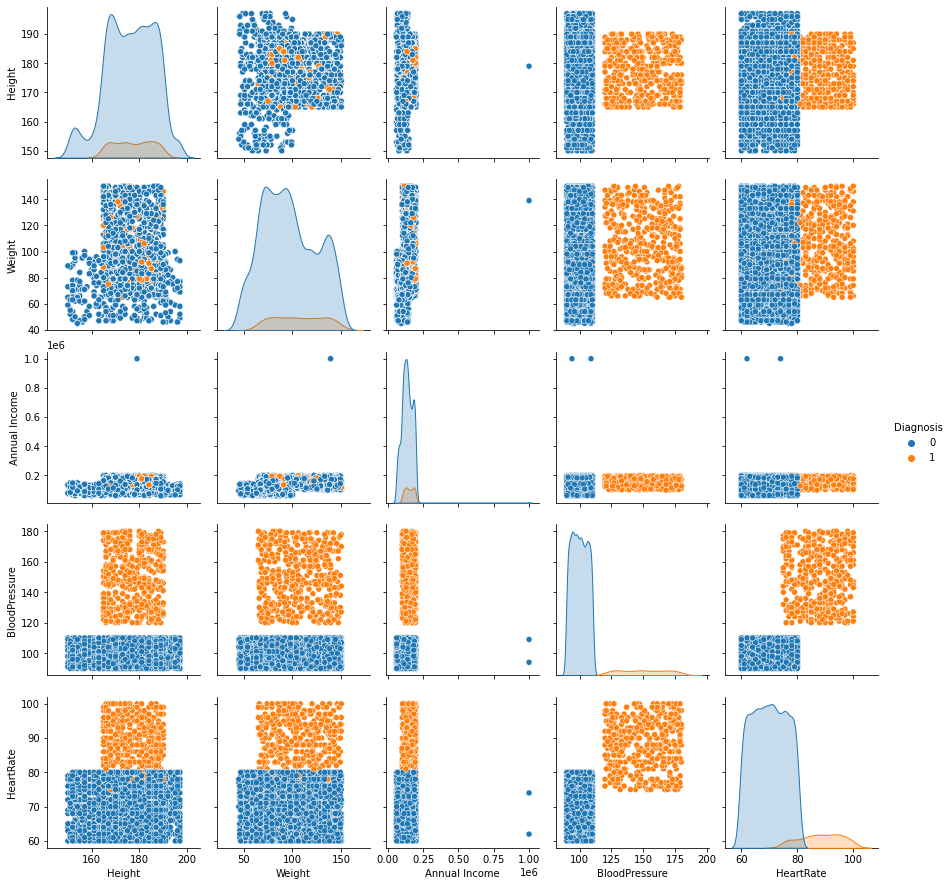

In [112]:
pairplot_data = combined_data.select("Height", "Weight", "Annual Income", "BloodPressure", "HeartRate", "Diagnosis").toPandas()
seaborn.pairplot(pairplot_data, hue='Diagnosis')
plt.show()

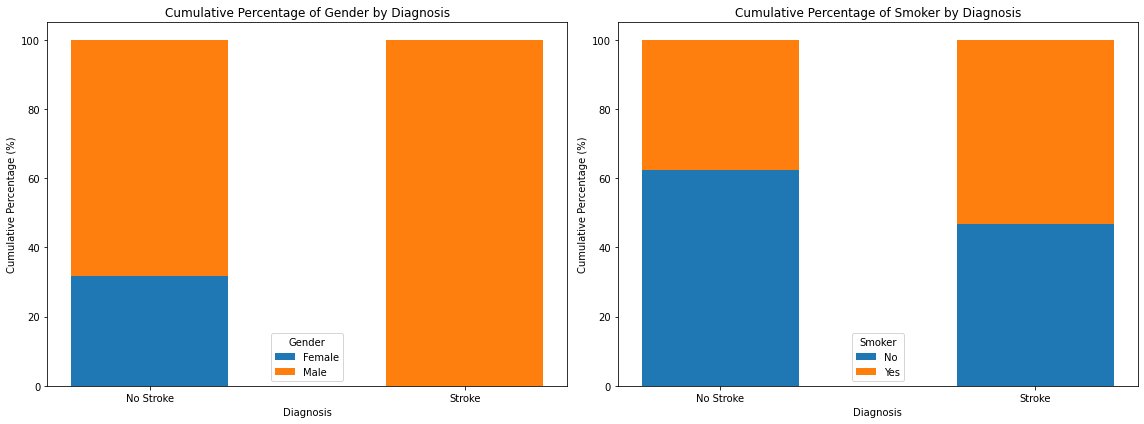

In [116]:
categorical_data = combined_data.select("Gender", "Smoker", "Diagnosis")

def plot_categorical_percentage(df, category, ax, title):
    # Calculate counts and percentages
    counts = df.groupby(['Diagnosis', category]).count()
    total_counts = df.groupby(['Diagnosis']).count().withColumnRenamed('count', 'TotalCount')
    percentages = counts.join(total_counts, on="Diagnosis", how="inner") \
                        .withColumn("Percentage", (f.col("count") * 100) / f.col("TotalCount"))

    # Pivot and convert to Pandas
    pivoted = percentages.groupBy('Diagnosis').pivot(category).sum('Percentage').fillna(0).toPandas()
    pivoted['Diagnosis'] = pivoted['Diagnosis'].astype('category')

    # Plot
    for col in pivoted.columns[1:]:
        ax.bar(pivoted['Diagnosis'], pivoted[col], label=col,
               bottom=pivoted.loc[:, pivoted.columns[1:]].cumsum(axis=1)[col] - pivoted[col], width=0.5)
    ax.set_xlabel('Diagnosis')
    ax.set_ylabel('Cumulative Percentage (%)')
    ax.set_title(title)
    ax.legend(title=category)
    ax.set_xticks(pivoted['Diagnosis'])
    ax.set_xticklabels(['Stroke', 'No Stroke'])

# Set up the figure for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Gender
plot_categorical_percentage(categorical_data, 'Gender', axes[0], 'Cumulative Percentage of Gender by Diagnosis')

# Plot for Smoker
plot_categorical_percentage(categorical_data, 'Smoker', axes[1], 'Cumulative Percentage of Smoker by Diagnosis')

plt.tight_layout()
plt.show()